## iPyLeaflet
[ipyleaflet](https://github.com/ellisonbg/ipyleaflet) is a bridge between jupyter notebooks and the [leaflet](http://leafletjs.com/)  javascript library for drawing maps.

ipyleaflet comes with a few examples notebooks (this notebook was derived from one) but very little documentation,
for more documentation read the [Leaflet IPA](http://leafletjs.com/reference.html)

For installation directions, see the README on [ipyleaflet](https://github.com/ellisonbg/ipyleaflet)

In [1]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

## Visualizing the distribution of the observations

## Load the required libraries

In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math

In [3]:
import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [4]:
import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

In [6]:
### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SBBBBBSB'
meas='SNWD'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print('keys from STAT=',STAT.keys())

#!ls -ld $data_dir/*.parquet

#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)

df=sqlContext.read.parquet(filename)
print(df.count())
df.show(2)

('keys from STAT=', ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP'])
798
+------------------+------------------+------------------+---------+--------+--------+---------+-----------+-------------------+-------------------+-------------------+-------------------+-----------+-----------+------+--------------------+------+
|           coeff_1|           coeff_2|           coeff_3|elevation|   label|latitude|longitude|measurement|              res_1|              res_2|              res_3|           res_mean|    station|  total_var|undefs|              vector|  year|
+------------------+------------------+------------------+---------+--------+--------+---------+-----------+-------------------+-------------------+-------------------+-------------------+-----------+-----------+------+--------------------+------+
| 1811.159502467558| 460.5274358673955| 343.3754609236406|    493.5|SBBBBBSB| 48.8217|-100.4525|       SNWD|0.21585999994825408|0.16516195320429547|0.13697690891565673| 0.32277648388

In [34]:
#extract longitude and latitude for each station
feature='coeff_2'
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT station, latitude,longitude,elevation,%s FROM weather"%feature
print(Query)
df1 = sqlContext.sql(Query)
df1.show(4)

SELECT station, latitude,longitude,elevation,coeff_2 FROM weather
+-----------+--------+---------+---------+------------------+
|    station|latitude|longitude|elevation|           coeff_2|
+-----------+--------+---------+---------+------------------+
|USC00320941| 48.8217|-100.4525|    493.5| 460.5274358673955|
|USC00320941| 48.8217|-100.4525|    493.5|273.33980279792246|
|CA005010191|    49.3|   -99.45|    482.0| 1343.217903574423|
|CA005010640|   49.55|   -99.08|    374.0| 96.44065865068956|
+-----------+--------+---------+---------+------------------+
only showing top 4 rows



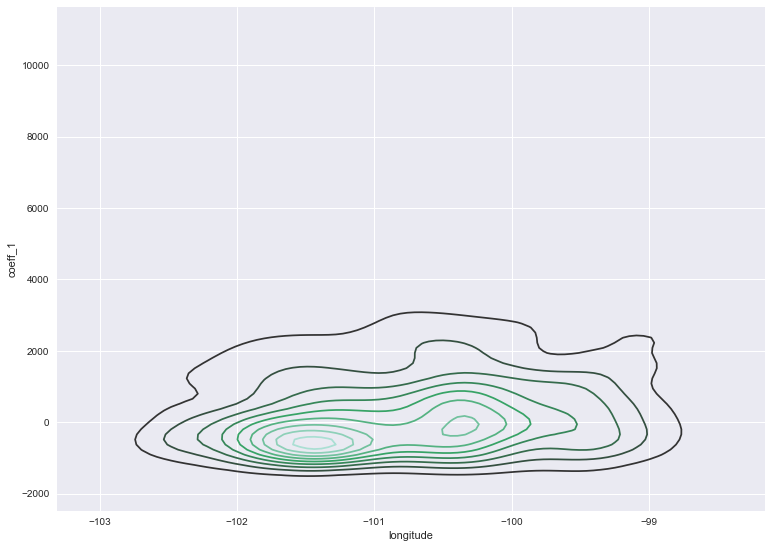

In [33]:

"""from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns

dfx = df1.toPandas()
fig, ax = plt.subplots()
fig.set_size_inches(12.7, 9.27)

sns.set_style('darkgrid')
sns.kdeplot(dfx.longitude, dfx.coeff_1)
fig.savefig('C:\\Users\\User\\Desktop\\longitude_stations_system_1.png')
"""


In [35]:
df2=df1.groupby(['station','latitude','longitude','elevation']).agg({"station": "count", feature: "mean"})
pdf=df2.toPandas()
pdf.sort_values(by=['station'],inplace=True)
pdf.head(2)

,station,latitude,longitude,elevation,count(station),avg(coeff_2)
44,CA004011250,49.22,-101.75,515.0,3,49.181891
21,CA004012485,49.33,-101.45,511.0,7,-268.135810


In [36]:
#define a mapping from the range of the value to hex colors.
from matplotlib.colors import rgb2hex
_avg='avg(%s)'%feature
_min=pdf[_avg].min()
_max=pdf[_avg].max()
_min,_max

import pylab as plt
cmap=plt.get_cmap('jet')
def get_color(val):
    x=(val-_min)/(_max-_min)
    return(rgb2hex(cmap(x)[:3]))

get_color(1000.)

u'#800000'

## Map

In [37]:
min_lat,max_lat,min_long,max_long = box = (49.22, 49.33, -101.75, -101.45)


In [38]:
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 9

m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
circles = []
for index,row in pdf.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    _count=row['count(station)']
    _coef=row[_avg]
    # taking sqrt of count so that the  area of the circle corresponds to the count
    c = Circle(location=(_lat,_long), radius=int(300*np.sqrt(_count+0.0)), weight=1,
            color='#F00', opacity=0.8, fill_opacity=0.4,
            fill_color=get_color(_coef))
    circles.append(c)
    m.add_layer(c)
m    

### excercises:
* Add a legend that relates the colors to values.
* Leaflet supports a variety of maps. See if you can get a topographical map as the background.

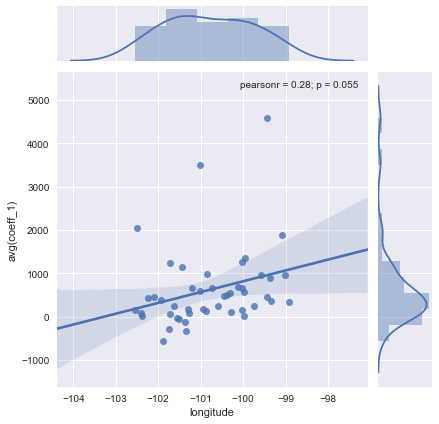

In [20]:
#%matplotlib inline
#pdf.plot.scatter(x='elevation',y='avg(coeff_1)');
from matplotlib import pyplot as plt
%matplotlib inline
#import pandas as pd

#df = pd.read_csv(filename)
import seaborn as sns

"""
sns.violinplot(x='measurement',
               y='res_3', 
               data=stats_df, 
               inner=None) # Remove the bars inside the violin
 
sns.swarmplot(x='measurement', 
              y='res_3', 
              data=stats_df, 
              color='k', # Make points black
              alpha=0.7) # and slightly transparent
 
# Set title with matplotlib
#plt.title('Attack by Type')
    
"""
g = sns.jointplot(x = 'longitude', y= 'avg(coeff_1)', data=pdf, kind="reg")
# New boxplot using stats_df
#sns.set_style("whitegrid")
#sns.violinplot(x='measurement', y='res_1', data=stats_df)
g.savefig('C:\\Users\\User\\Desktop\\5_longitude_avgcoeff.png')